# **Import required libraries**

In [ ]:
import numpy as np
import scipy 
import librosa
import matplotlib.pyplot as plt
import os
import time
from scipy.io import loadmat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Preprocessing**

In [ ]:
def make_Logpatches_matlab(gtgram, patch_width=64, patch_height=64, overlap=0):
  # overlap = 0.5 for train
  # print(gtgram.shape)
  patches = [gtgram[:patch_height, i:i+patch_width] for i in range(0,gtgram.shape[1], int(patch_width*(1-overlap)))]
  if patches[-2].shape[1]<64:
    patches[-2] = np.pad(patches[-2], ((0,0), (0,64-patches[-2].shape[1])), 'constant', constant_values=0 )
  if patches[-1].shape[1]<64:
    patches[-1] = np.pad(patches[-1], ((0,0), (0,64-patches[-1].shape[1])), 'constant', constant_values=0 ) 
  return patches

def get_crops_matlab(root,filename,overlap):
    gtgram = loadmat(root + filename)

    # Normalisation
    gtgram['Feat'] = (gtgram['Feat'] - gtgram['Feat'].min() ) / (gtgram['Feat'].max() - gtgram['Feat'].min()) 
    gtgram['Clean_cent'] = (gtgram['Clean_cent'] - gtgram['Clean_cent'].min() ) / (gtgram['Clean_cent'].max() - gtgram['Clean_cent'].min()) 

    # Standardisation
    # gtgram['Feat'] = (gtgram['Feat'] - gtgram['Feat'].mean() ) / gtgram['Feat'].std()
    # gtgram['Clean_cent'] = (gtgram['Clean_cent'] - gtgram['Clean_cent'].mean() ) / gtgram['Clean_cent'].std()
    
    crops_input = make_Logpatches_matlab(gtgram['Feat'],overlap=overlap)
    crops_output = make_Logpatches_matlab(gtgram['Clean_cent'],overlap=overlap)

    return gtgram['Feat'], gtgram['Clean_cent'], crops_input, crops_output   
    
def save_log_gtgrams(inputs, path, filename):
  for i in range(len(inputs)):
    np.save(path+filename+'_'+str(i+1)+'.npy', inputs[i])

# **Train dataset**

### **Load MATLAB generated trainset**

In [ ]:
!unzip -q 'drive/MyDrive/Speech_Project/Training_complementary_feats.zip' -d '/content/'

In [ ]:
os.mkdir('/content/train_input')
os.mkdir('/content/train_output')

In [ ]:
trainset = sorted(os.listdir('/content/Training_complementary_feats/'))
root = '/content/Training_complementary_feats/'

### **Example of 64*64 patch generation**

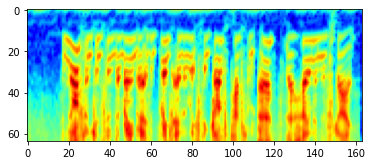

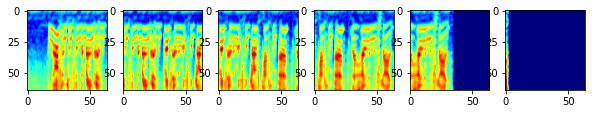

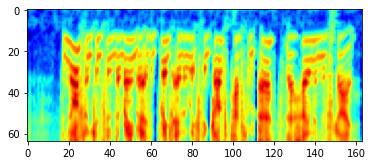

0.521330539682961 0.1994438965411427


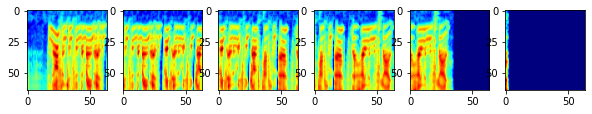

In [ ]:
filename = trainset[5]

input, output, crops_input, crops_output  = get_crops_matlab(root,filename,0.5)
plt.figure(figsize = (6,4))
plt.imshow(input,cmap = 'jet')
plt.show()

fig, ax = plt.subplots(1,len(crops_input),figsize = (10,8))
for i in range(len(crops_input)):
  ax[i].imshow(crops_input[i], cmap='jet')
plt.show()

plt.figure(figsize = (6,4))
plt.imshow(output,cmap = 'jet')
plt.show()

print(output.mean(), output.std())

fig, ax = plt.subplots(1,len(crops_output),figsize = (10,8))
for i in range(len(crops_output)):
  ax[i].imshow(crops_output[i], cmap='jet')
plt.show()

### **Preprocess and save trainset**

In [ ]:
s = time.time()

## Save noisy trainset and clean trainset in colab

for i, filename in enumerate(sorted(trainset)):
      _, _, crops_input, crops_output = get_crops_matlab(root,filename,0.5)
      save_log_gtgrams(crops_input, '/content/train_input/', filename.split('.')[0])
      save_log_gtgrams(crops_output, '/content/train_output/', filename.split('.')[0])
      print(i)
print(time.time() - s)   

In [ ]:
!mkdir 'train_16k_standardisation_zeroPadded'

In [ ]:
## Save patched output to GDrive

!zip -q -r train_16k_standardisation_zeroPadded.zip 'train_16k_standardisation_zeroPadded'
#!zip -q -g train_matlab_normalised.zip -r 'train_output'
!cp '/content/train_16k_standardisation_zeroPadded.zip' '/content/drive/My Drive/Speech_Project/'

In [ ]:
!unzip -q '/content/drive/My Drive/Speech_Project/train_16k_standardisation_zeroPadded.zip' -d '/content/'

In [ ]:
len(os.listdir('train_16k_standardisation_zeroPadded/train_input')), len(os.listdir('train_16k_standardisation_zeroPadded/train_output'))

(40332, 40332)

## **Test dataset**

### **Load MATLAB generated testset**

In [ ]:
!unzip -q 'drive/MyDrive/Speech_Project/Testing_complementary_feats.zip' -d '/content/'

In [ ]:
os.mkdir('/content/test_input')
os.mkdir('/content/test_output')

In [ ]:
testset = sorted(os.listdir('/content/Testing_complementary_feats/'))
root = '/content/Testing_complementary_feats/'

### **Example of 64*64 patched test set**

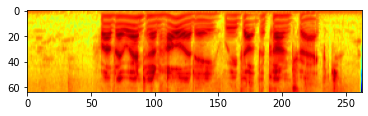

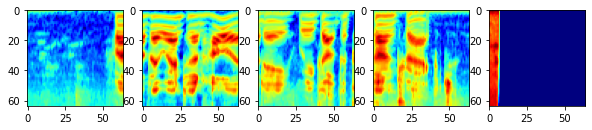

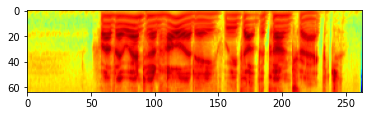

0.7685053494824862 0.11158321956824213


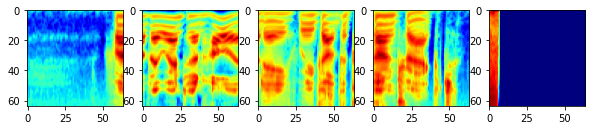

In [ ]:
## Create patches: Example

filename = testset[5]

input, output, crops_input, crops_output  = get_crops_matlab(root,filename,0)     # Set overlap to 0 for testing
plt.figure(figsize = (6,4))
plt.imshow(input,cmap = 'jet')
plt.show()

fig, ax = plt.subplots(1,len(crops_input),figsize = (10,8))
for i in range(len(crops_input)):
  ax[i].imshow(crops_input[i], cmap='jet')
plt.show()

plt.figure(figsize = (6,4))
plt.imshow(output,cmap = 'jet')
plt.show()

print(output.mean(), output.std())

fig, ax = plt.subplots(1,len(crops_output),figsize = (10,8))
for i in range(len(crops_output)):
  ax[i].imshow(crops_output[i], cmap='jet')
plt.show()

### **Preprocess and save testset**

In [ ]:
s = time.time()

## Save noisy testset and clean testset in colab

for i, filename in enumerate(sorted(testset)):
      _, _, crops_input, crops_output = get_crops_matlab(root,filename,0)
      save_log_gtgrams(crops_input, '/content/test_input/', filename.split('.')[0])
      save_log_gtgrams(crops_output, '/content/test_output/', filename.split('.')[0])
      print(i)
print(time.time() - s)   

In [ ]:
!mkdir 'test_16k_standardisation_zeroPadded'

In [ ]:
!mv test_input test_16k_standardisation_zeroPadded
!mv test_output test_16k_standardisation_zeroPadded

In [ ]:
## Save patched output to GDrive

!zip -q -r test_16k_standardisation_zeroPadded.zip 'test_16k_standardisation_zeroPadded'
#!zip -q -g train_matlab_normalised.zip -r 'train_output'
!cp '/content/test_16k_standardisation_zeroPadded.zip' '/content/drive/My Drive/Speech_Project/'

In [ ]:
!unzip -q '/content/drive/My Drive/Speech_Project/test_16k_standardisation_zeroPadded.zip' -d '/content/'

In [ ]:
len(os.listdir('test_16k_standardisation_zeroPadded/test_input')), len(os.listdir('test_16k_standardisation_zeroPadded/test_output'))

(3635, 3635)